In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest



In [2]:
df = pd.read_csv('df_alldata.csv')

In [3]:
# Dataframe with funnel errors 

# Convert the 'date_time' column to datetime type
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort the data by 'client_id', 'visitor_id', 'visit_id', and 'date_time' in ascending order
df_sorted = df.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'], ascending=[True, True, True, True])

# Define the expected process_step order
expected_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Initialize the "errors" column
df_sorted['errors'] = ''

# Group the data by visit_id to evaluate each session
def evaluate_funnel(group):
    process_steps = group['process_step'].tolist()

    # Case 1: Visit_id has exactly the 5 steps in the correct order
    if process_steps == expected_steps:
        group['errors'] = 'correct_funnel_order_complete'
    
    # Case 2: Visit_id has all 5 steps but in the wrong order or with extra steps
    elif all(step in process_steps for step in expected_steps) and process_steps[-1] == 'confirm':
        group['errors'] = 'incorrect_funnel_order_complete'
    
    # Case 3: Visit_id does not have all 5 distinct steps
    else:
        group['errors'] = 'funnel_error'

    return group

# Apply the function to each visit_id group
df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/3822145233.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_errors = df_sorted.groupby('visit_id').apply(evaluate_funnel)


In [4]:
df_with_errors.to_csv("df_with_errors.csv")

In [5]:
# Dataframe with success column

In [6]:
# Create the new column 'funnel_success' based on the 'errors' column
df_with_errors['funnel_success'] = df_with_errors['errors'].apply(lambda x: 0 if x == 'funnel_error' else 1)

In [7]:
df = df_with_errors
df.to_csv("df_with_success.csv")

In [8]:
# Group by 'client_id', then for each 'client_id', get the unique 'visit_id' and calculate the % of successful funnels
success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/2037172356.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_percentage = df.groupby('client_id').apply(lambda group: pd.Series({


In [9]:
success_percentage.value_counts()

client_id  unique_visit_ids  success_percentage
555        1.0               100.000000            1
6685212    1.0               100.000000            1
6683515    1.0               100.000000            1
6683529    1.0               100.000000            1
6683623    1.0               100.000000            1
                                                  ..
3366593    1.0               100.000000            1
3366892    2.0               85.714286             1
3366913    1.0               100.000000            1
3367073    2.0               83.333333             1
9999729    2.0               0.000000              1
Name: count, Length: 40017, dtype: int64

In [10]:
# Calculate the average number of visits per client_id
average_visits_per_client = success_percentage['unique_visit_ids'].mean()

# Calculate the overall average success rate (amount of success funnel / amount of visit_id)
average_success_rate = df.groupby('client_id')['funnel_success'].mean().mean() * 100

average_visits_per_client, average_success_rate


(1.3038208761276457, 56.76317223405627)

In [11]:
# Grouping the data by 'client_id' and 'variation' to perform comparison between Test and Control groups
comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({
    'unique_visit_ids': group['visit_id'].nunique(),
    'success_percentage': group['funnel_success'].mean() * 100
})).reset_index()

# Calculate the average number of visits per client_id and success rate for Test and Control groups
comparison_summary = comparison.groupby('variation').agg({
    'unique_visit_ids': 'mean',
    'success_percentage': 'mean'
}).reset_index()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/3112683169.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comparison = df.groupby(['variation', 'client_id']).apply(lambda group: pd.Series({


In [12]:
comparison_summary

,variation,unique_visit_ids,success_percentage
0,Control,1.296985,53.714009
1,Test,1.309416,59.258786


In [13]:
# Remove unnecessary columns and keep the relevant ones
df_clean = df[['visit_id', 'client_id', 'variation', 'funnel_success']]

# Group by client_id to calculate the total visits and average success rate for each client
client_visits = df_clean.groupby('client_id').agg(
    total_visits=('visit_id', 'nunique'), 
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

# Overall analysis
overall_total_visits = client_visits['total_visits'].sum()
overall_avg_success_rate = client_visits['avg_success_rate'].mean()

# Comparative analysis by test vs control groups
variation_grouped = df_clean.groupby(['variation', 'client_id']).agg(
    total_visits=('visit_id', 'nunique'),
    avg_success_rate=('funnel_success', 'mean')
).reset_index()

test_group = variation_grouped[variation_grouped['variation'] == 'Test']
control_group = variation_grouped[variation_grouped['variation'] == 'Control']

test_avg_visits = test_group['total_visits'].mean()
test_avg_success_rate = test_group['avg_success_rate'].mean()

control_avg_visits = control_group['total_visits'].mean()
control_avg_success_rate = control_group['avg_success_rate'].mean()

# Display overall and comparative results
overall_results = {
    'Overall Total Visits': overall_total_visits,
    'Overall Average Success Rate': overall_avg_success_rate,
    'Test Group Average Visits': test_avg_visits,
    'Test Group Average Success Rate': test_avg_success_rate,
    'Control Group Average Visits': control_avg_visits,
    'Control Group Average Success Rate': control_avg_success_rate
}

overall_results


{'Overall Total Visits': 52175,
 'Overall Average Success Rate': 0.5676317223405627,
 'Test Group Average Visits': 1.3094156139234754,
 'Test Group Average Success Rate': 0.5925878625850841,
 'Control Group Average Visits': 1.2969851757259452,
 'Control Group Average Success Rate': 0.5371400882158088}

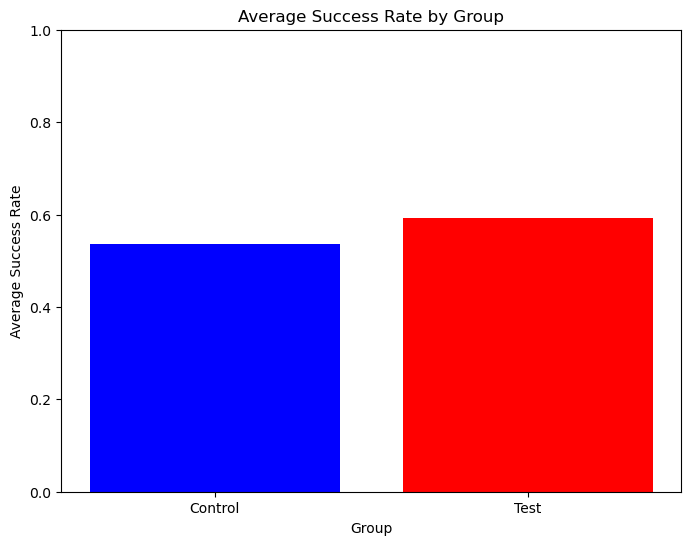

In [14]:
# Plot the success rates by group
groups = ['Control', 'Test']
success_rates = [control_avg_success_rate, test_avg_success_rate]

plt.figure(figsize=(8, 6))
plt.bar(groups, success_rates, color=['blue', 'red'])
plt.xlabel('Group')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate by Group')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/767436914.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_new = df.groupby('age_group_new').agg(


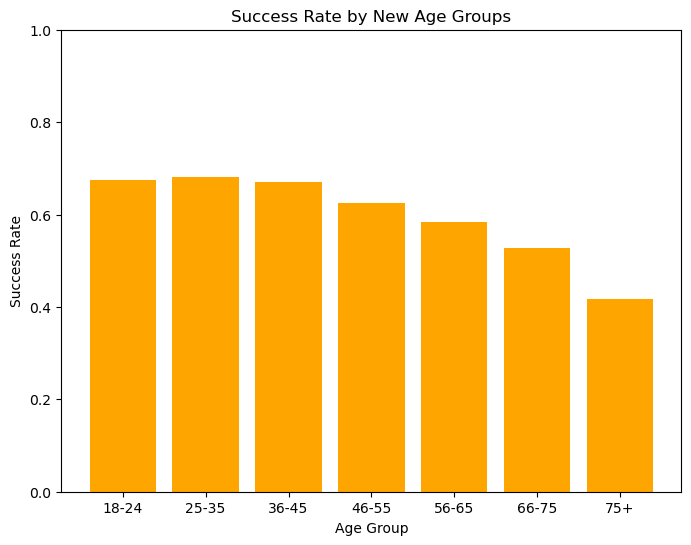

In [15]:
# Modify the age bins and labels as per the new ranges
age_bins_new = [18, 24, 35, 45, 55, 65, 75, 100]
age_labels_new = ['18-24', '25-35', '36-45', '46-55', '56-65', '66-75', '75+']
df['age_group_new'] = pd.cut(df['age'], bins=age_bins_new, labels=age_labels_new)

# Group by the new age groups to calculate the success rate for each group
success_rate_by_age_new = df.groupby('age_group_new').agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Plot the success rate by the new age group
plt.figure(figsize=(8, 6))
plt.bar(success_rate_by_age_new['age_group_new'], success_rate_by_age_new['success_rate'], color='orange')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by New Age Groups')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages

# Display the plot
plt.show()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/1117169872.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(


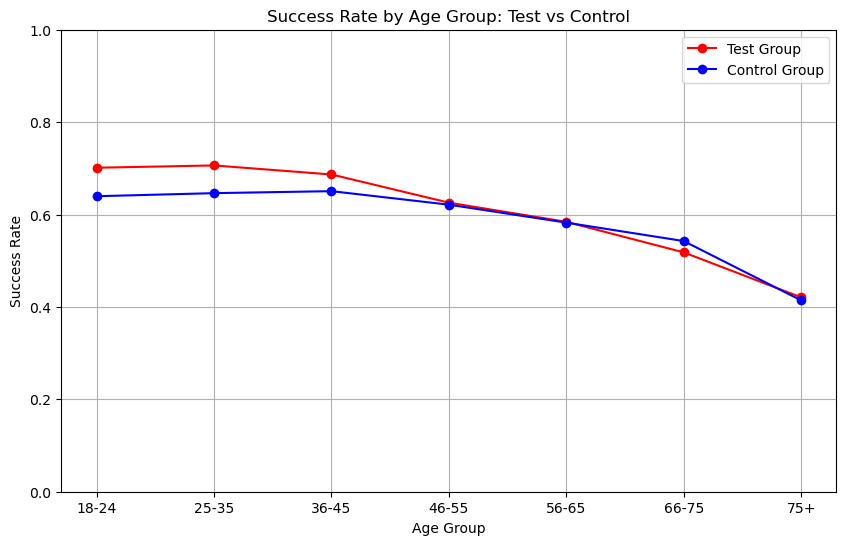

In [16]:
# Group by age group and variation to calculate success rate for Test and Control groups
success_rate_by_age_group_variation = df.groupby(['age_group_new', 'variation']).agg(
    total_visits=('visit_id', 'nunique'),
    success_rate=('funnel_success', 'mean')
).reset_index()

# Separate data for Test and Control groups
test_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Test']
control_data = success_rate_by_age_group_variation[success_rate_by_age_group_variation['variation'] == 'Control']

# Plot the success rates by age group for Test and Control
plt.figure(figsize=(10, 6))
plt.plot(test_data['age_group_new'], test_data['success_rate'], marker='o', label='Test Group', color='red')
plt.plot(control_data['age_group_new'], control_data['success_rate'], marker='o', label='Control Group', color='blue')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.title('Success Rate by Age Group: Test vs Control')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 to represent percentages
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [17]:

# Calculate success rate based on unique successful visits (1 success max per visit)
df_unique_visits = df_clean.drop_duplicates(subset=['visit_id'])

# Group by variation to calculate the number of visits and the rate of successful visits
visits_and_success_unique = df_unique_visits.groupby('variation').agg(
    total_visits=('visit_id', 'nunique'),
    successful_visits=('funnel_success', 'sum')
).reset_index()

# Calculate success rate (successful visits / total visits)
visits_and_success_unique['success_rate'] = visits_and_success_unique['successful_visits'] / visits_and_success_unique['total_visits']

# Display the updated success rate
visits_and_success_unique



,variation,total_visits,successful_visits,success_rate
0,Control,23273,10264,0.441026
1,Test,28709,14017,0.488244


In [18]:
from scipy import stats
import numpy as np

# Prepare data for two-sample t-test
control_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Control']['funnel_success']
test_success_rates = df_unique_visits[df_unique_visits['variation'] == 'Test']['funnel_success']

# Perform two-sample t-test
t_stat, p_value_ttest = stats.ttest_ind(control_success_rates, test_success_rates)

# Prepare data for chi-square test (success vs failure for control and test groups)
control_successes = control_success_rates.sum()
control_failures = len(control_success_rates) - control_successes
test_successes = test_success_rates.sum()
test_failures = len(test_success_rates) - test_successes

# Create a contingency table
contingency_table = np.array([[control_successes, control_failures], [test_successes, test_failures]])

# Perform chi-square test
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)

# Output the results of both tests
t_test_results = {
    't_statistic': t_stat,
    'p_value_ttest': p_value_ttest
}

chi2_test_results = {
    'chi2_statistic': chi2_stat,
    'p_value_chi2': p_value_chi2
}

t_test_results, chi2_test_results


({'t_statistic': -10.741417690133224, 'p_value_ttest': 6.940818820769825e-27},
 {'chi2_statistic': 114.9373352939181, 'p_value_chi2': 8.12240401629767e-27})

In [19]:
# Calculate the difference in success rates
success_rate_difference = test_avg_success_rate - control_avg_success_rate

# Determine if the A/B test is successful based on the 5% criterion
is_successful = success_rate_difference >= 0.05

# Create a summary of the results
results_summary = {
    'Test Group Success Rate (%)': round(test_avg_success_rate * 100, 2),
    'Control Group Success Rate (%)': round(control_avg_success_rate * 100, 2),
    'Success Rate Difference (%)': round(success_rate_difference * 100, 2),
    'Is A/B Test Successful (5% criterion)': is_successful,
    't-test p-value': p_value_ttest,
    'Chi-square p-value': p_value_chi2
}

results_summary


{'Test Group Success Rate (%)': 59.26,
 'Control Group Success Rate (%)': 53.71,
 'Success Rate Difference (%)': 5.54,
 'Is A/B Test Successful (5% criterion)': True,
 't-test p-value': 6.940818820769825e-27,
 'Chi-square p-value': 8.12240401629767e-27}

In [20]:
# Deduplicate the data by unique visit_id and client_id, keeping only one success or failure per unique visit
df_dedup = df_clean.drop_duplicates(subset=['visit_id', 'client_id'])

# Group by client_id and variation to calculate unique visits and success rate, ensuring only one success or failure per visit
client_visit_success_updated = df_dedup.groupby(['client_id', 'variation']).agg(
    unique_visits=('visit_id', 'nunique'),
    total_successes=('funnel_success', 'sum')
).reset_index()

# Calculate the success rate per client (based on one success or failure per unique visit)
client_visit_success_updated['success_rate'] = client_visit_success_updated['total_successes'] / client_visit_success_updated['unique_visits']

# Separate data for Test and Control groups
client_visit_success_updated_test = client_visit_success_updated[client_visit_success_updated['variation'] == 'Test']
client_visit_success_updated_control = client_visit_success_updated[client_visit_success_updated['variation'] == 'Control']

# Display the first few rows of the updated analysis for both groups
client_visit_success_updated_test.head(), client_visit_success_updated_control.head()




(   client_id variation  unique_visits  total_successes  success_rate
 0        555      Test              1                1           1.0
 1        647      Test              1                1           1.0
 2        934      Test              1                0           0.0
 8       1516      Test              2                1           0.5
 9       1643      Test              2                0           0.0,
    client_id variation  unique_visits  total_successes  success_rate
 3       1028   Control              1                0           0.0
 4       1186   Control              2                0           0.0
 5       1195   Control              1                1           1.0
 6       1197   Control              1                1           1.0
 7       1368   Control              1                0           0.0)

In [21]:
# Calculate the average success rate across all clients for Test and Control groups
avg_success_rate_test = client_visit_success_updated_test['success_rate'].mean()
avg_success_rate_control = client_visit_success_updated_control['success_rate'].mean()

# Summarize the average success rates
success_rate_summary = {
    'Average Success Rate - Test Group (%)': round(avg_success_rate_test * 100, 2),
    'Average Success Rate - Control Group (%)': round(avg_success_rate_control * 100, 2)
}

success_rate_summary


{'Average Success Rate - Test Group (%)': 56.05,
 'Average Success Rate - Control Group (%)': 50.93}

In [22]:
df_with_success = pd.read_csv("df_with_success.csv")
df_with_success

,visit_id,Unnamed: 1,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,calls_semester,logons_semester,balance_thousands,visitor_id,visit_id.1,process_step,date_time,errors,funnel_success
0,100012776_37918976071_457913,111379,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,funnel_error,0
1,100012776_37918976071_457913,111378,3561384,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,63.13,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,funnel_error,0
2,100019538_17884295066_43909,246767,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,incorrect_funnel_order_complete,1
3,100019538_17884295066_43909,246766,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,incorrect_funnel_order_complete,1
4,100019538_17884295066_43909,246765,7338123,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,26.44,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,incorrect_funnel_order_complete,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241146,999988789_76411676596_272843,99589,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,funnel_error,0
241147,999988789_76411676596_272843,99588,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,funnel_error,0
241148,999988789_76411676596_272843,99587,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,funnel_error,0
241149,999988789_76411676596_272843,99586,6627522,Test,18.0,227.0,58.0,F,2.0,1056775.54,6.0,9.0,1056.78,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,funnel_error,0


In [23]:

# Step 1: Convert 'date_time' to datetime format
df_with_success['date_time'] = pd.to_datetime(df_with_success['date_time'], errors='coerce')

# Step 2: Sort by client_id, visit_id, and date_time to ensure proper sequence
df_with_success = df_with_success.sort_values(by=['client_id', 'visit_id', 'date_time'], ignore_index=True)

# Step 3: Calculate 'time_spent' as the difference between consecutive steps within the same client and visit
df_with_success['next_date_time'] = df_with_success.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
df_with_success['time_spent'] = (df_with_success['next_date_time'] - df_with_success['date_time']).dt.total_seconds()

# Step 4: Remove rows where 'time_spent' is NaN, which indicates the last step in each sequence
df_steps_duration_corrected = df_with_success.dropna(subset=['time_spent'])

# Step 5: Remove the 'confirm' step, as it's the final step and shouldn't have a following step
df_steps_duration_corrected = df_steps_duration_corrected[df_steps_duration_corrected['process_step'] != 'confirm']

# Step 6: Recalculate the average time spent per step, grouped by 'variation' and 'process_step'
avg_step_duration_corrected = df_steps_duration_corrected.groupby(['variation', 'process_step'])['time_spent'].mean().reset_index()
avg_step_duration_corrected.rename(columns={'time_spent': 'avg_time_spent_seconds'}, inplace=True)

# Display the final corrected results
print(avg_step_duration_corrected)

  variation process_step  avg_time_spent_seconds
0   Control        start               68.900262
1   Control       step_1               47.337968
2   Control       step_2               92.559155
3   Control       step_3              143.655161
4      Test        start               60.200626
5      Test       step_1               62.049775
6      Test       step_2               88.366531
7      Test       step_3              131.994556


In [24]:
# Convert the 'date_time' column to datetime type
df_with_success['date_time'] = pd.to_datetime(df_with_success['date_time'])

# Group by 'visit_id' and calculate the time difference for each visit
df_with_success['visit_duration_seconds'] = df_with_success.groupby('visit_id')['date_time'].transform(lambda x: (x.max() - x.min()).total_seconds())

df_with_success


,visit_id,Unnamed: 1,client_id,variation,tenure_year,tenure_month,age,gender,accounts,balance,...,balance_thousands,visitor_id,visit_id.1,process_step,date_time,errors,funnel_success,next_date_time,time_spent,visit_duration_seconds
0,637149525_38041617439_716659,73801,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,correct_funnel_order_complete,1,2017-04-15 12:58:03,7.0,158.0
1,637149525_38041617439_716659,73800,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,correct_funnel_order_complete,1,2017-04-15 12:58:35,32.0,158.0
2,637149525_38041617439_716659,73799,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,correct_funnel_order_complete,1,2017-04-15 13:00:14,99.0,158.0
3,637149525_38041617439_716659,73798,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,correct_funnel_order_complete,1,2017-04-15 13:00:34,20.0,158.0
4,637149525_38041617439_716659,73797,555,Test,3.0,46.0,29.5,U,2.0,25454.66,...,25.45,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,correct_funnel_order_complete,1,NaT,NaN,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241146,493310979_9209676464_421146,109815,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,step_1,2017-04-20 14:22:49,funnel_error,0,2017-04-20 14:27:36,287.0,450.0
241147,493310979_9209676464_421146,109814,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,step_2,2017-04-20 14:27:36,funnel_error,0,2017-04-20 14:28:57,81.0,450.0
241148,493310979_9209676464_421146,109813,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,843385170_36953471821,493310979_9209676464_421146,start,2017-04-20 14:28:57,funnel_error,0,NaT,NaN,450.0
241149,99583652_41711450505_426179,109812,9999729,Test,10.0,124.0,31.0,F,3.0,107059.74,...,107.06,604429154_69247391147,99583652_41711450505_426179,start,2017-04-05 13:40:49,funnel_error,0,2017-04-05 13:41:04,15.0,15.0


In [25]:
# Calculate the average visit duration for successful vs unsuccessful funnels
avg_duration_by_success = df_with_success.groupby('funnel_success')['visit_duration_seconds'].mean()

# Calculate the average visit duration for test vs control groups
avg_duration_by_group = df_with_success.groupby('variation')['visit_duration_seconds'].mean()

# Display the results
avg_duration_by_success, avg_duration_by_group


(funnel_success
 0    452.276329
 1    503.624113
 Name: visit_duration_seconds, dtype: float64,
 variation
 Control    448.247269
 Test       509.946966
 Name: visit_duration_seconds, dtype: float64)

In [26]:
# Group by both funnel success and variation to calculate the average visit duration
avg_duration_by_success_and_group = df_with_success.groupby(['funnel_success', 'variation'])['visit_duration_seconds'].mean()

# Display the result
avg_duration_by_success_and_group


funnel_success  variation
0               Control      412.571833
                Test         482.484295
1               Control      471.324734
                Test         526.443078
Name: visit_duration_seconds, dtype: float64

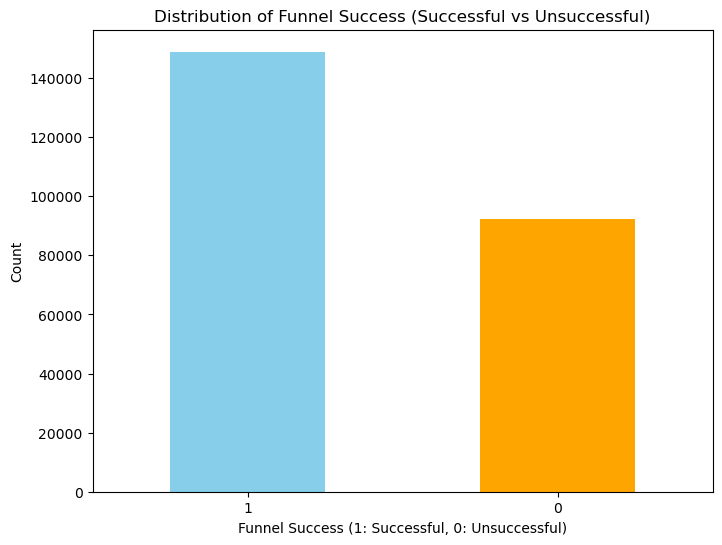

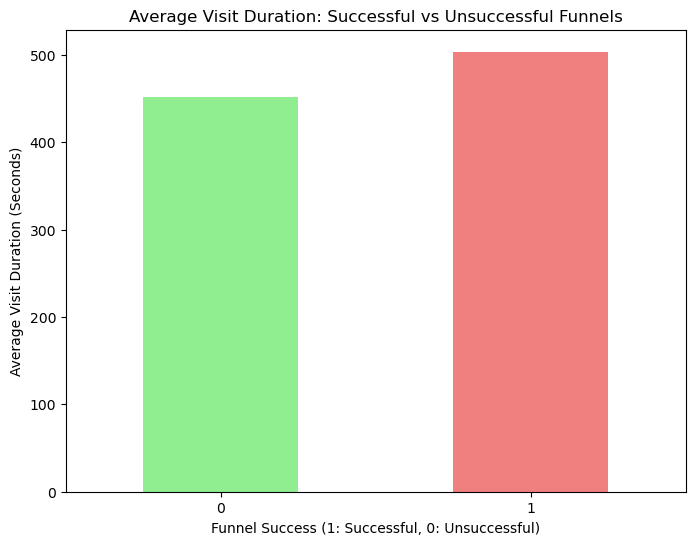

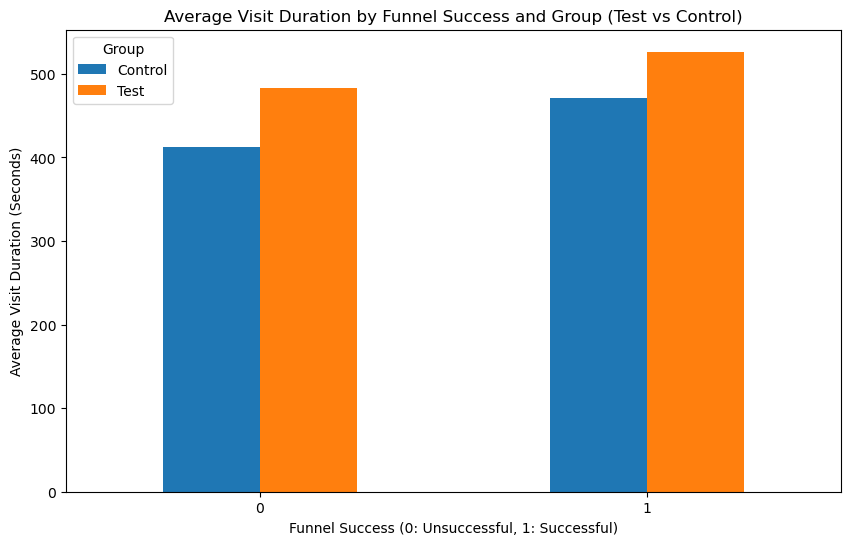

In [27]:
# Funnel success distribution
plt.figure(figsize=(8,6))
df['funnel_success'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Funnel Success (Successful vs Unsuccessful)')
plt.xlabel('Funnel Success (1: Successful, 0: Unsuccessful)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Average visit duration: successful vs unsuccessful funnels
plt.figure(figsize=(8,6))
avg_duration_by_success.plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Average Visit Duration: Successful vs Unsuccessful Funnels')
plt.xlabel('Funnel Success (1: Successful, 0: Unsuccessful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Average visit duration: test vs control groups for successful/unsuccessful funnels
avg_duration_by_success_and_group.unstack().plot(kind='bar', figsize=(10,6))
plt.title('Average Visit Duration by Funnel Success and Group (Test vs Control)')
plt.xlabel('Funnel Success (0: Unsuccessful, 1: Successful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.legend(title="Group", loc='upper left')
plt.show()


In [28]:
df = df_with_success

In [35]:
# 2. Average Visit Duration (Control vs. Test)
avg_duration_by_group = df.groupby('variation')['visit_duration_seconds'].mean()

# 3. Age Distribution (Control vs. Test)
avg_age_by_group = df.groupby('variation')['age'].mean()

# 4. Tenure Year and Month Comparison (Control vs. Test)
avg_tenure_year_by_group = df.groupby('variation')['tenure_year'].mean()
avg_tenure_month_by_group = df.groupby('variation')['tenure_month'].mean()

# 5. Number of Accounts (Control vs. Test)
avg_accounts_by_group = df.groupby('variation')['accounts'].mean()

# 6. Balance Distribution (Control vs. Test)
avg_balance_by_group = df.groupby('variation')['balance'].mean()

# 7. Calls per Semester (Control vs. Test)
avg_calls_by_group = df.groupby('variation')['calls_semester'].mean()

# 8. Logons per Semester (Control vs. Test)
avg_logons_by_group = df.groupby('variation')['logons_semester'].mean()

# 9. Visit Success Based on Gender (Control vs. Test)
success_rate_by_gender_and_group = df.groupby(['gender', 'variation'])['funnel_success'].mean()

# 10. Balance for Successful Funnels (Control vs. Test)
avg_balance_successful_by_group = df[df['funnel_success'] == 1].groupby('variation')['balance'].mean()

# 11. Visit Duration for Successful Funnels (Control vs. Test)
avg_duration_successful_by_group = df[df['funnel_success'] == 1].groupby('variation')['visit_duration_seconds'].mean()

# 12. Visit Duration for Unsuccessful Funnels (Control vs. Test)
avg_duration_unsuccessful_by_group = df[df['funnel_success'] == 0].groupby('variation')['visit_duration_seconds'].mean()

# 13. Success Rate for Different Age Groups (Control vs. Test)
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100], labels=['<18', '18-35', '35-50', '50-65', '65+'])
success_rate_by_age_group = df.groupby(['age_group', 'variation'])['funnel_success'].mean()

# 14. Impact of Account Balance on Funnel Success (Control vs. Test)
balance_success_rate = df.groupby(pd.cut(df['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()

# 15. Relationship Between Logons and Funnel Success (Control vs. Test)
logon_success_rate = df.groupby(pd.cut(df['logons_semester'], bins=[0, 5, 10, 20, 50]))['funnel_success'].mean()

# Display all the calculated insights
{
    "Average Visit Duration by Group": avg_duration_by_group,
    "Average Age by Group": avg_age_by_group,
    "Average Tenure Year by Group": avg_tenure_year_by_group,
    "Average Tenure Month by Group": avg_tenure_month_by_group,
    "Average Accounts by Group": avg_accounts_by_group,
    "Average Balance by Group": avg_balance_by_group,
    "Average Calls by Group": avg_calls_by_group,
    "Average Logons by Group": avg_logons_by_group,
    "Success Rate by Gender and Group": success_rate_by_gender_and_group,
    "Average Balance for Successful Funnels by Group": avg_balance_successful_by_group,
    "Average Duration for Successful Funnels by Group": avg_duration_successful_by_group,
    "Average Duration for Unsuccessful Funnels by Group": avg_duration_unsuccessful_by_group,
    "Success Rate by Age Group": success_rate_by_age_group,
    "Balance Success Rate": balance_success_rate,
    "Logon Success Rate": logon_success_rate
}

/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/1098013589.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group = df.groupby(['age_group', 'variation'])['funnel_success'].mean()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/1098013589.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_success_rate = df.groupby(pd.cut(df['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/1098013589.py:43: FutureWarning: The default of observed=False is deprecated an

{'Average Visit Duration by Group': variation
 Control    448.247269
 Test       509.946966
 Name: visit_duration_seconds, dtype: float64,
 'Average Age by Group': variation
 Control    48.274144
 Test       48.804026
 Name: age, dtype: float64,
 'Average Tenure Year by Group': variation
 Control    12.090252
 Test       12.153982
 Name: tenure_year, dtype: float64,
 'Average Tenure Month by Group': variation
 Control    151.093936
 Test       151.900019
 Name: tenure_month, dtype: float64,
 'Average Accounts by Group': variation
 Control    2.272410
 Test       2.253427
 Name: accounts, dtype: float64,
 'Average Balance by Group': variation
 Control    160221.922984
 Test       161112.719731
 Name: balance, dtype: float64,
 'Average Calls by Group': variation
 Control    3.168346
 Test       3.153395
 Name: calls_semester, dtype: float64,
 'Average Logons by Group': variation
 Control    6.205103
 Test       6.193482
 Name: logons_semester, dtype: float64,
 'Success Rate by Gender and

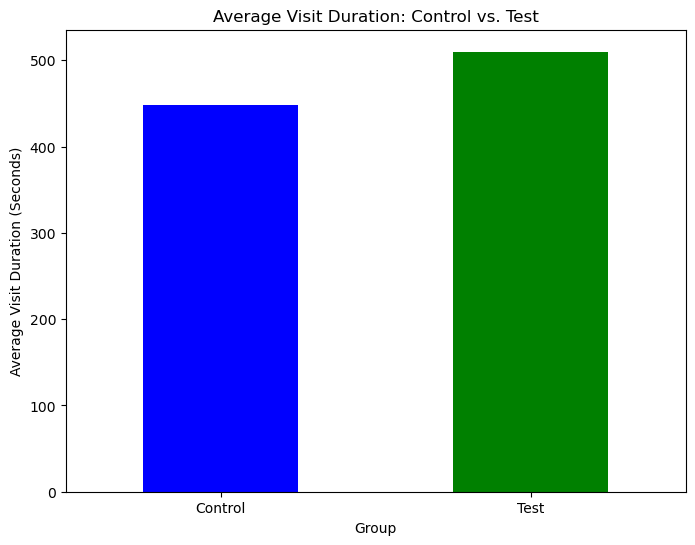

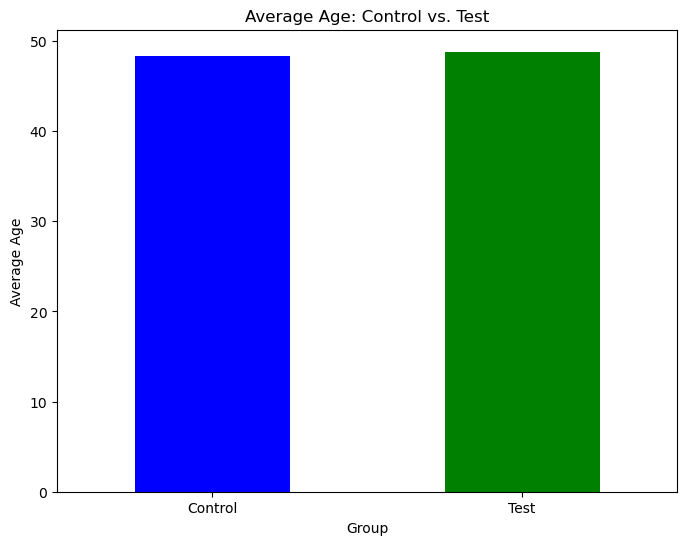

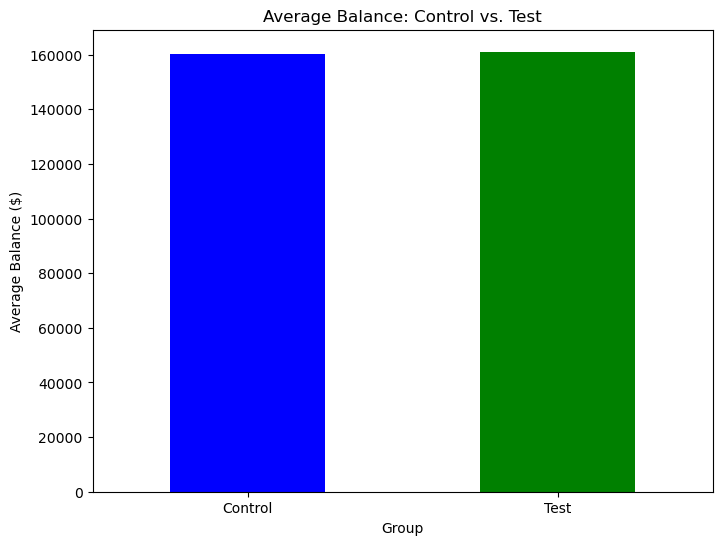

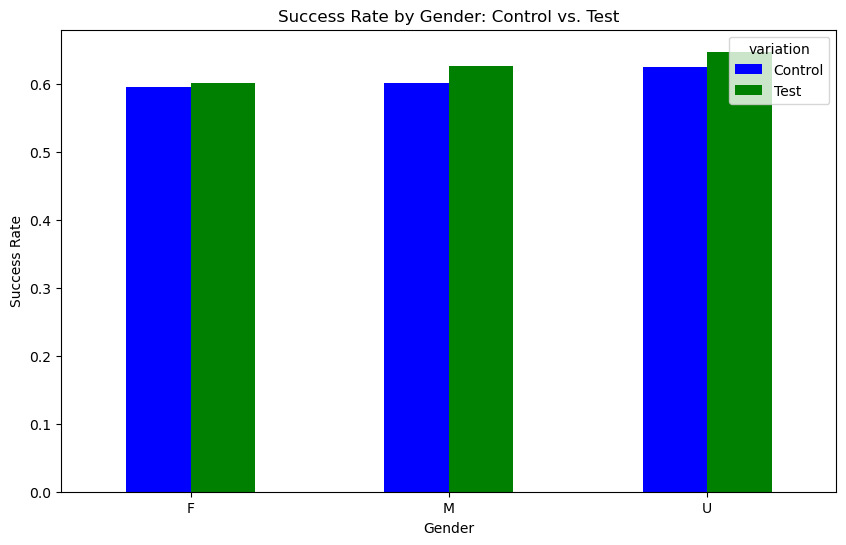

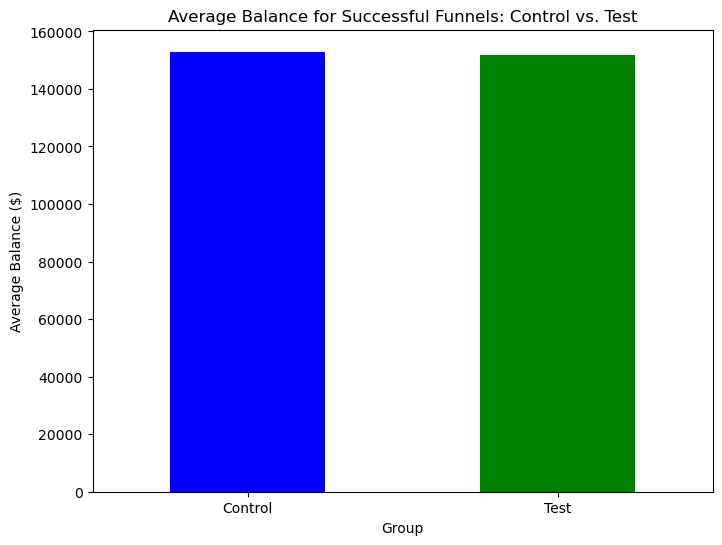

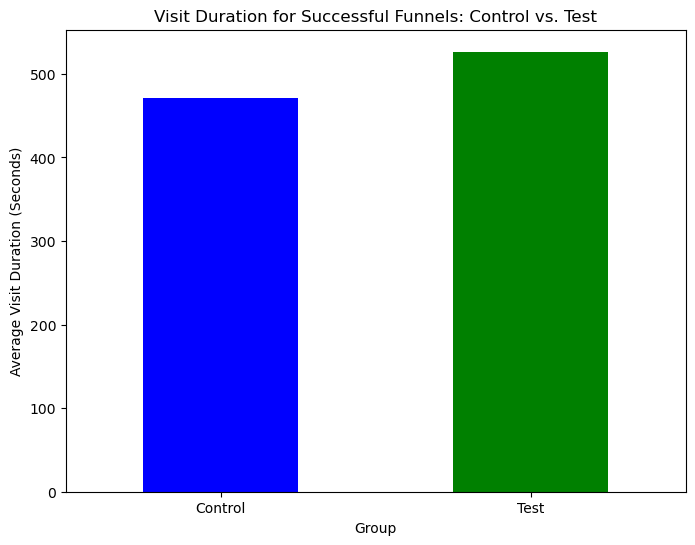

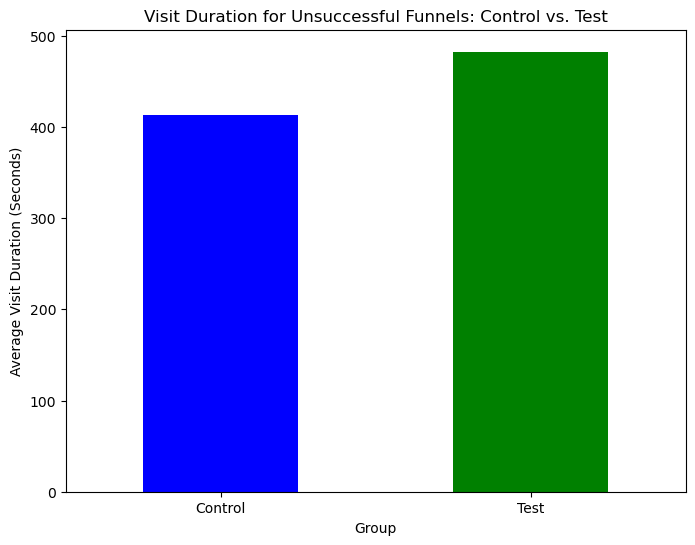

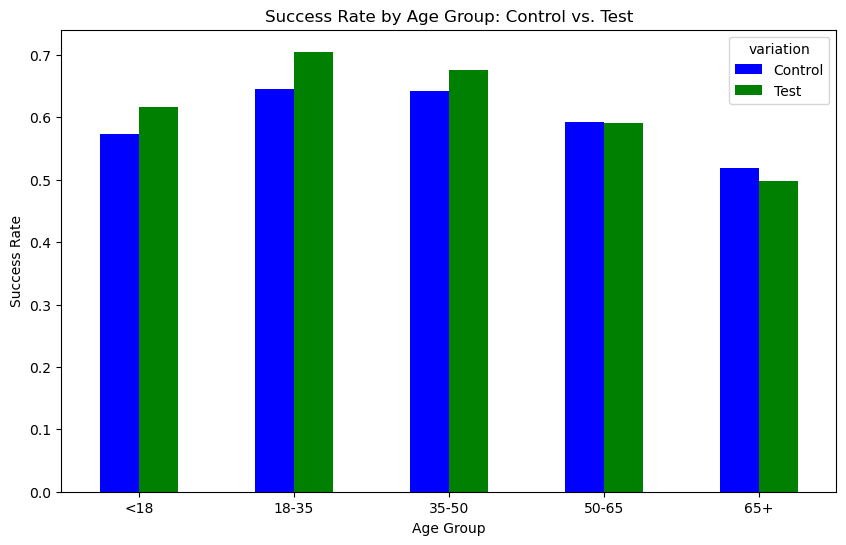

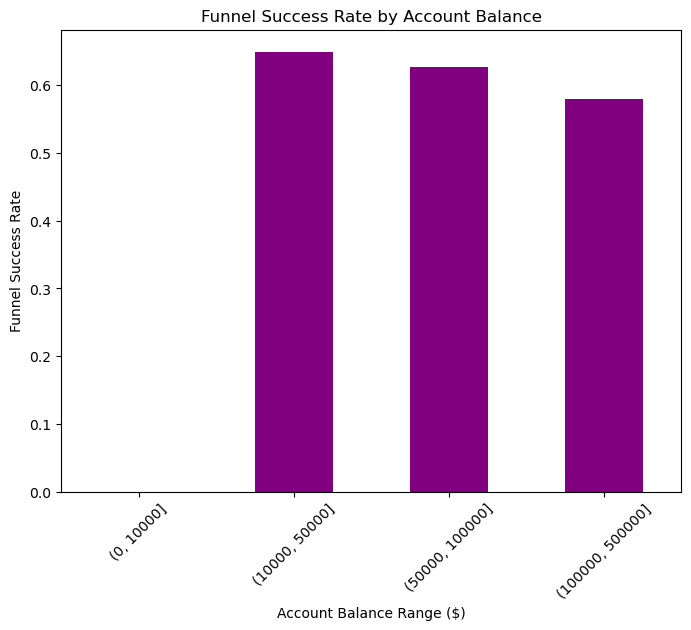

In [36]:
# Focus on relevant insights:
# We will remove the less relevant analyses such as tenure, number of accounts, calls per semester, and logons per semester.

# Relevant analyses:
# 1. Success Rates by Group
# 2. Average Visit Duration by Group
# 3. Age Distribution (Control vs. Test)
# 4. Balance Distribution (Control vs. Test)
# 5. Success Rate by Gender and Group
# 6. Balance for Successful Funnels (Control vs. Test)
# 7. Visit Duration for Successful Funnels (Control vs. Test)
# 8. Visit Duration for Unsuccessful Funnels (Control vs. Test)
# 9. Success Rate by Age Group
# 10. Impact of Balance on Funnel Success

# Plotting graphs for relevant insights

# Plot 2: Average Visit Duration by Group
plt.figure(figsize=(8,6))
avg_duration_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Visit Duration: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 3: Age Distribution (Control vs. Test)
plt.figure(figsize=(8,6))
avg_age_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Age: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Age')
plt.xticks(rotation=0)
plt.show()

# Plot 4: Balance Distribution (Control vs. Test)
plt.figure(figsize=(8,6))
avg_balance_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Balance: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Balance ($)')
plt.xticks(rotation=0)
plt.show()

# Plot 5: Success Rate by Gender and Group
success_rate_by_gender_and_group.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Gender: Control vs. Test')
plt.xlabel('Gender')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 6: Balance for Successful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_balance_successful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Balance for Successful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Balance ($)')
plt.xticks(rotation=0)
plt.show()

# Plot 7: Visit Duration for Successful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_duration_successful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Visit Duration for Successful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 8: Visit Duration for Unsuccessful Funnels (Control vs. Test)
plt.figure(figsize=(8,6))
avg_duration_unsuccessful_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Visit Duration for Unsuccessful Funnels: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()

# Plot 9: Success Rate by Age Group (Control vs. Test)
success_rate_by_age_group.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Age Group: Control vs. Test')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 10: Impact of Balance on Funnel Success
plt.figure(figsize=(8,6))
balance_success_rate.plot(kind='bar', color='purple')
plt.title('Funnel Success Rate by Account Balance')
plt.xlabel('Account Balance Range ($)')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=45)
plt.show()


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/2879472102.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_by_age_group_unique = df_unique_visits.groupby(['age_group', 'variation'])['funnel_success'].mean()
/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/2879472102.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_success_rate_unique = df_unique_visits.groupby(pd.cut(df_unique_visits['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()


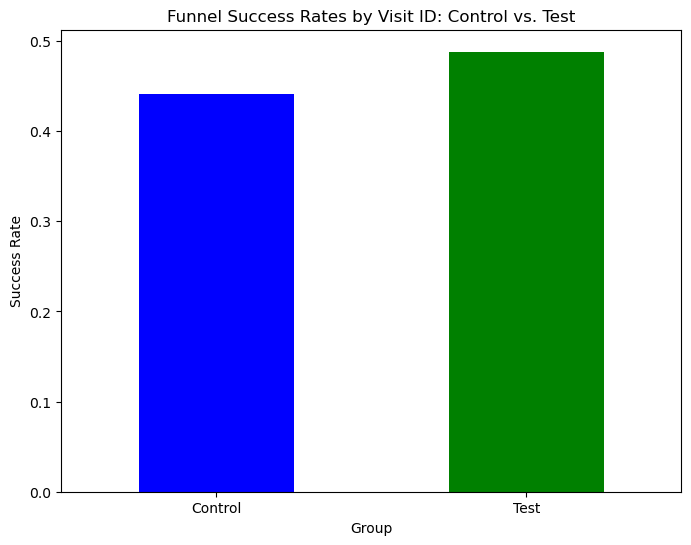

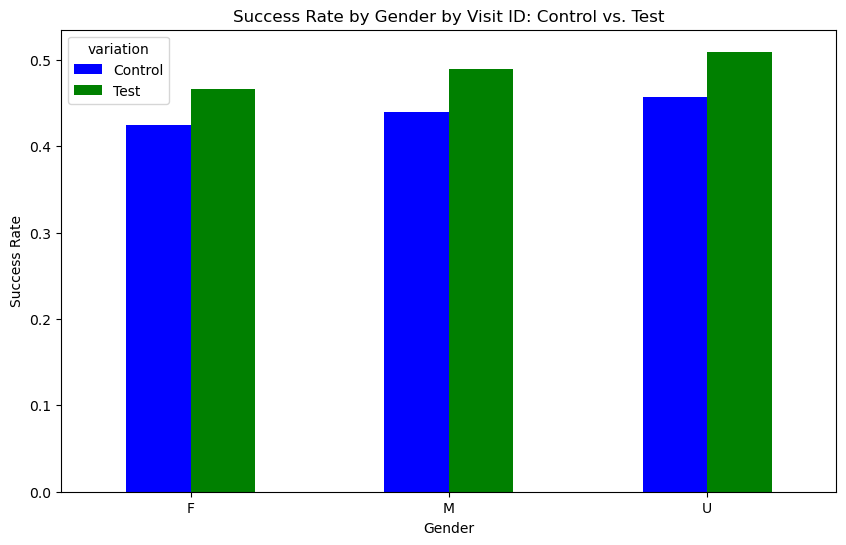

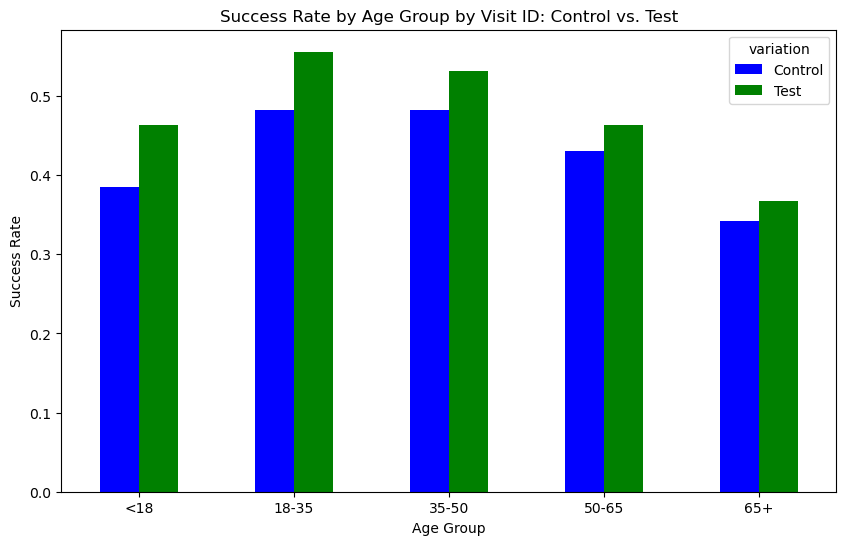

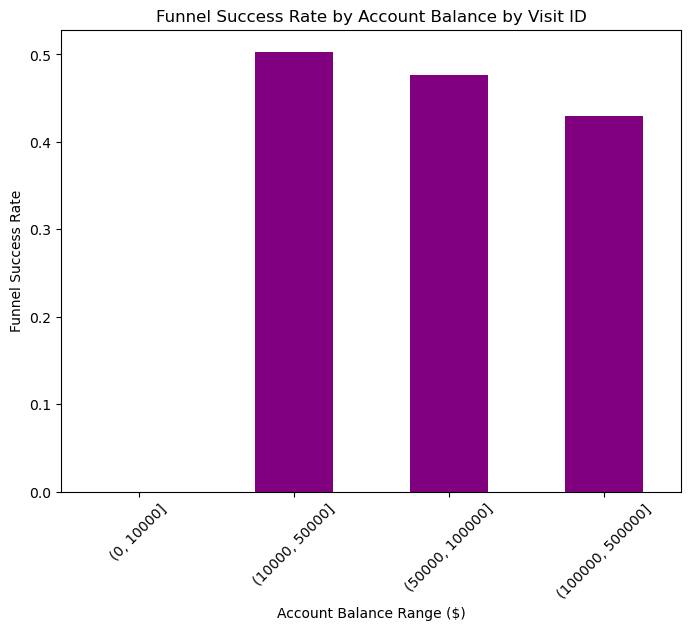

In [38]:
# To calculate the success rate correctly, we need to count only one "funnel success" per visit_id.
# First, we will drop duplicates by visit_id and take the first row for each unique visit_id.

# Remove duplicates to count success per visit_id
df_unique_visits = df.drop_duplicates(subset=['visit_id'], keep='first')

# Recalculate success rates by group (Control vs. Test)
success_rates_by_group_unique = df_unique_visits.groupby('variation')['funnel_success'].mean()

# Recalculate success rate by gender and group (Control vs. Test)
success_rate_by_gender_and_group_unique = df_unique_visits.groupby(['gender', 'variation'])['funnel_success'].mean()

# Recalculate success rate by age group (Control vs. Test)
success_rate_by_age_group_unique = df_unique_visits.groupby(['age_group', 'variation'])['funnel_success'].mean()

# Recalculate balance success rate (Funnel success based on balance ranges)
balance_success_rate_unique = df_unique_visits.groupby(pd.cut(df_unique_visits['balance'], bins=[0, 10000, 50000, 100000, 500000]))['funnel_success'].mean()

# Plot 1: Success Rates by Group (unique visits)
plt.figure(figsize=(8,6))
success_rates_by_group_unique.plot(kind='bar', color=['blue', 'green'])
plt.title('Funnel Success Rates by Visit ID: Control vs. Test')
plt.xlabel('Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 2: Success Rate by Gender and Group (unique visits)
success_rate_by_gender_and_group_unique.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Gender by Visit ID: Control vs. Test')
plt.xlabel('Gender')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 3: Success Rate by Age Group (unique visits)
success_rate_by_age_group_unique.unstack().plot(kind='bar', figsize=(10,6), color=['blue', 'green'])
plt.title('Success Rate by Age Group by Visit ID: Control vs. Test')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.show()

# Plot 4: Impact of Balance on Funnel Success by Visit ID (unique visits)
plt.figure(figsize=(8,6))
balance_success_rate_unique.plot(kind='bar', color='purple')
plt.title('Funnel Success Rate by Account Balance by Visit ID')
plt.xlabel('Account Balance Range ($)')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=45)
plt.show()


In [39]:
success_rates_by_group_unique

variation
Control    0.441026
Test       0.488244
Name: funnel_success, dtype: float64

In [40]:
# To analyze the success rate for clients (unique client_id), we need to group by client_id and count one "funnel success" per visit_id.

# Remove duplicates to count success per visit_id (unique client_id and visit_id)
df_unique_visits_by_client = df.drop_duplicates(subset=['visit_id', 'client_id'], keep='first')

# Calculate the average success rate for unique client_id, grouped by their visit_id success
success_rate_by_client = df_unique_visits_by_client.groupby('client_id')['funnel_success'].mean()

# Calculate overall average success rate across all clients
average_success_rate_by_client = success_rate_by_client.mean()

# Display the average success rate for clients
average_success_rate


56.76317223405627

In [41]:
# Calculate the average success rate for clients in Control vs. Test groups
success_rate_by_client_and_group = df_unique_visits_by_client.groupby(['variation', 'client_id'])['funnel_success'].mean()

# Calculate overall average success rate across all clients for Control vs Test
average_success_rate_by_client_and_group = success_rate_by_client_and_group.groupby('variation').mean()

# Display the average success rate for clients by group (Control vs Test)
average_success_rate_by_client_and_group


variation
Control    0.509262
Test       0.560491
Name: funnel_success, dtype: float64

In [42]:
# Analyze the impact of age on funnel success
# Group the data by age bins and calculate the average funnel success rate for each age group
age_bins = pd.cut(df_unique_visits_by_client['age'], bins=[18, 25, 35, 45, 55, 65, 75, 100], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+'])
age_success_rate = df_unique_visits_by_client.groupby(age_bins)['funnel_success'].mean()

# Display the success rate by age group
age_success_rate


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/3586710806.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_success_rate = df_unique_visits_by_client.groupby(age_bins)['funnel_success'].mean()


age
18-25    0.517733
25-35    0.526804
35-45    0.516724
45-55    0.481979
55-65    0.442505
65-75    0.377739
75+      0.274397
Name: funnel_success, dtype: float64

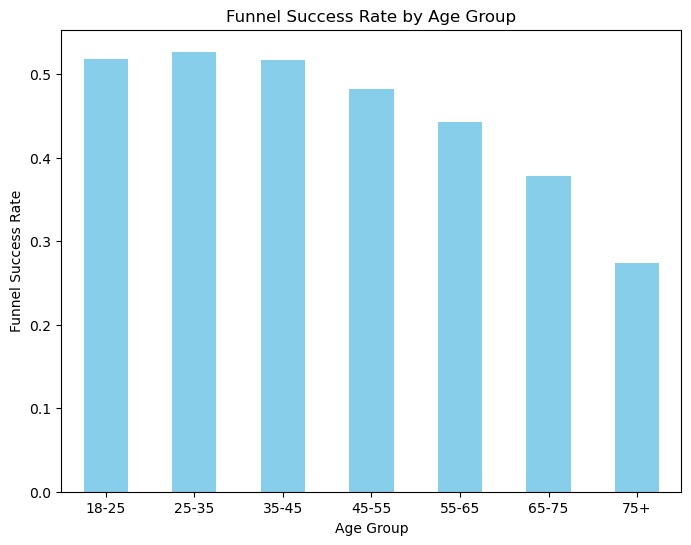

In [43]:
# Plotting the success rate by age group
plt.figure(figsize=(8,6))
age_success_rate.plot(kind='bar', color='skyblue')
plt.title('Funnel Success Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Funnel Success Rate')
plt.xticks(rotation=0)
plt.show()


In [44]:
# Recalculate the age bins with the new ranges provided
age_bins_new = pd.cut(df_unique_visits_by_client['age'], bins=[18, 25, 35, 45, 55, 65, 75, 100], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+'])

# Calculate the average time spent per visit_id for each age group
avg_time_spent_by_age_group = df_unique_visits_by_client.groupby(age_bins_new)['visit_duration_seconds'].mean()

# Display the average time spent by age group
avg_time_spent_by_age_group


/var/folders/5j/rbw66y292j36gxy345r1m_sw0000gn/T/ipykernel_16871/3950567156.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_time_spent_by_age_group = df_unique_visits_by_client.groupby(age_bins_new)['visit_duration_seconds'].mean()


age
18-25    251.410465
25-35    249.293229
35-45    279.865470
45-55    334.206989
55-65    356.462481
65-75    350.051855
75+      354.506889
Name: visit_duration_seconds, dtype: float64

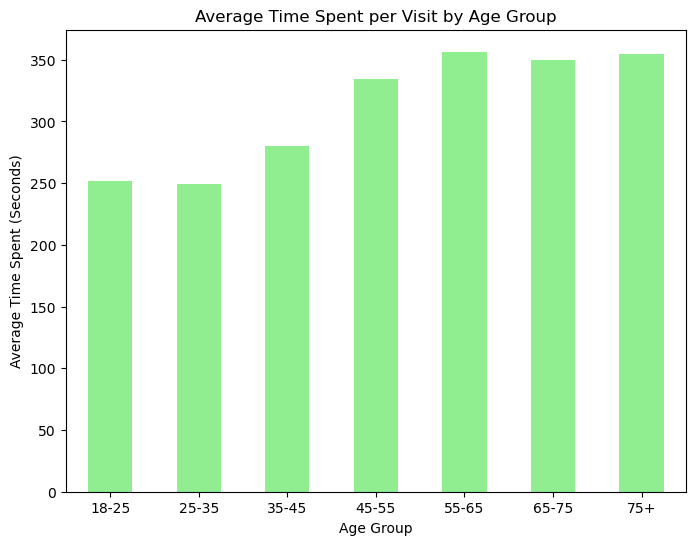

In [45]:
# Plotting the average time spent by age group
plt.figure(figsize=(8,6))
avg_time_spent_by_age_group.plot(kind='bar', color='lightgreen')
plt.title('Average Time Spent per Visit by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Time Spent (Seconds)')
plt.xticks(rotation=0)
plt.show()


In [46]:
# Analyze the impact of visit time on funnel success
# Group the data by funnel success and calculate the average visit duration for successful vs unsuccessful funnels
visit_time_success_impact = df_unique_visits_by_client.groupby('funnel_success')['visit_duration_seconds'].mean()

# Display the result
visit_time_success_impact


funnel_success
0    213.442501
1    422.995704
Name: visit_duration_seconds, dtype: float64

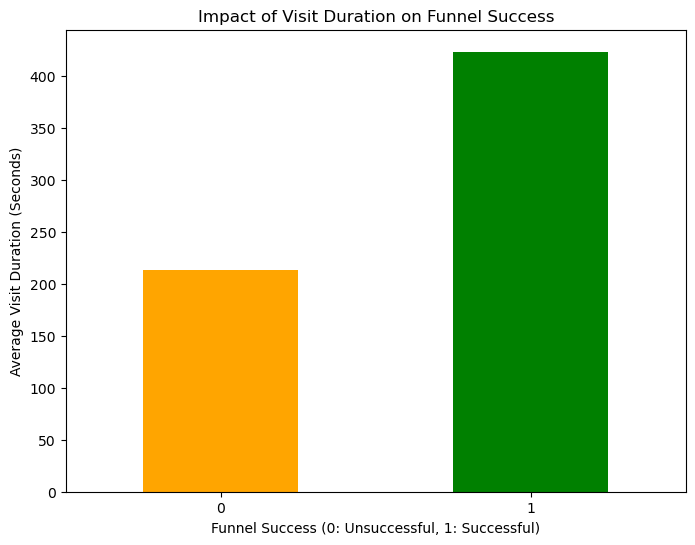

In [47]:
# Plotting the average visit duration for successful vs unsuccessful funnels
plt.figure(figsize=(8,6))
visit_time_success_impact.plot(kind='bar', color=['orange', 'green'])
plt.title('Impact of Visit Duration on Funnel Success')
plt.xlabel('Funnel Success (0: Unsuccessful, 1: Successful)')
plt.ylabel('Average Visit Duration (Seconds)')
plt.xticks(rotation=0)
plt.show()


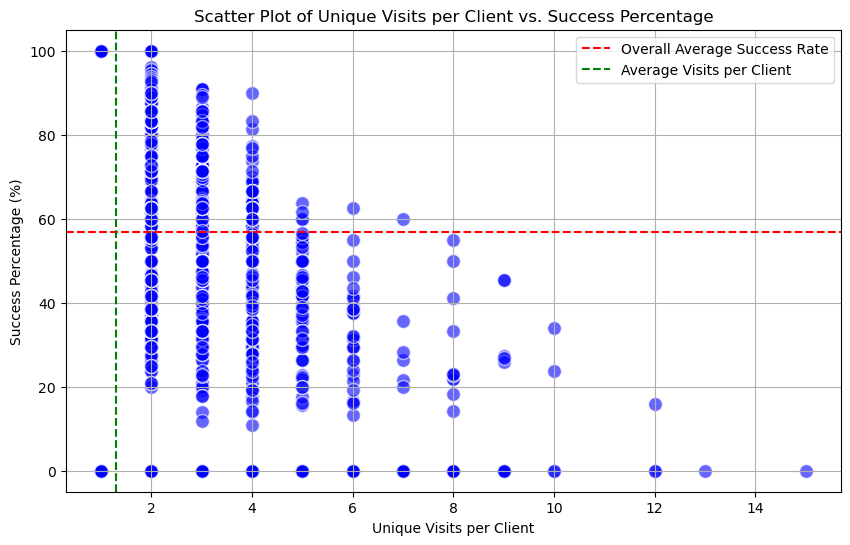

In [48]:
# Scatter plot of the average visits per client against the success rate for each client
plt.figure(figsize=(10, 6))
plt.scatter(success_percentage['unique_visit_ids'], success_percentage['success_percentage'], color='blue', s=100, alpha=0.6, edgecolors='w')
plt.axhline(average_success_rate, color='r', linestyle='--', label='Overall Average Success Rate')
plt.axvline(average_visits_per_client, color='g', linestyle='--', label='Average Visits per Client')
plt.title('Scatter Plot of Unique Visits per Client vs. Success Percentage')
plt.xlabel('Unique Visits per Client')
plt.ylabel('Success Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Step 1: Convert 'date_time' to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Step 2: Sort by client_id, visit_id, and date_time to ensure proper sequence
df = df.sort_values(by=['client_id', 'visit_id', 'date_time'], ignore_index=True)

# Step 3: Calculate 'time_spent' as the difference between consecutive steps within the same client and visit
df['next_date_time'] = df.groupby(['client_id', 'visit_id'])['date_time'].shift(-1)
df['time_spent'] = (df['next_date_time'] - df['date_time']).dt.total_seconds()

# Step 4: Remove rows where 'time_spent' is NaN, which indicates the last step in each sequence
df_steps_duration_corrected = df.dropna(subset=['time_spent'])

# Step 5: Remove the 'confirm' step, as it's the final step and shouldn't have a following step
df_steps_duration_corrected = df_steps_duration_corrected[df_steps_duration_corrected['process_step'] != 'confirm']

# Step 6: Recalculate the average time spent per step, grouped by 'variation' and 'process_step'
avg_step_duration_corrected = df_steps_duration_corrected.groupby(['variation', 'process_step'])['time_spent'].mean().reset_index()
avg_step_duration_corrected.rename(columns={'time_spent': 'avg_time_spent_seconds'}, inplace=True)

# Display the final corrected results
print(avg_step_duration_corrected)

  variation process_step  avg_time_spent_seconds
0   Control        start               68.900262
1   Control       step_1               47.337968
2   Control       step_2               92.559155
3   Control       step_3              143.655161
4      Test        start               60.200626
5      Test       step_1               62.049775
6      Test       step_2               88.366531
7      Test       step_3              131.994556


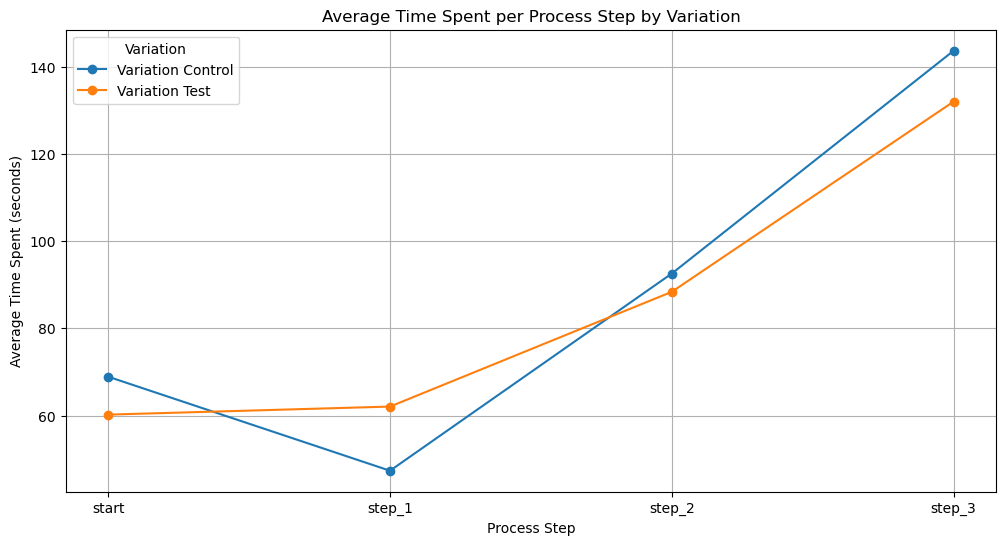

In [50]:
plt.figure(figsize=(12, 6))
for variation in avg_step_duration_corrected['variation'].unique():
    subset = avg_step_duration_corrected[avg_step_duration_corrected['variation'] == variation]
    plt.plot(subset['process_step'], subset['avg_time_spent_seconds'], marker='o', label=f'Variation {variation}')

plt.title('Average Time Spent per Process Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (seconds)')
plt.legend(title='Variation')
plt.grid(True)
plt.show()

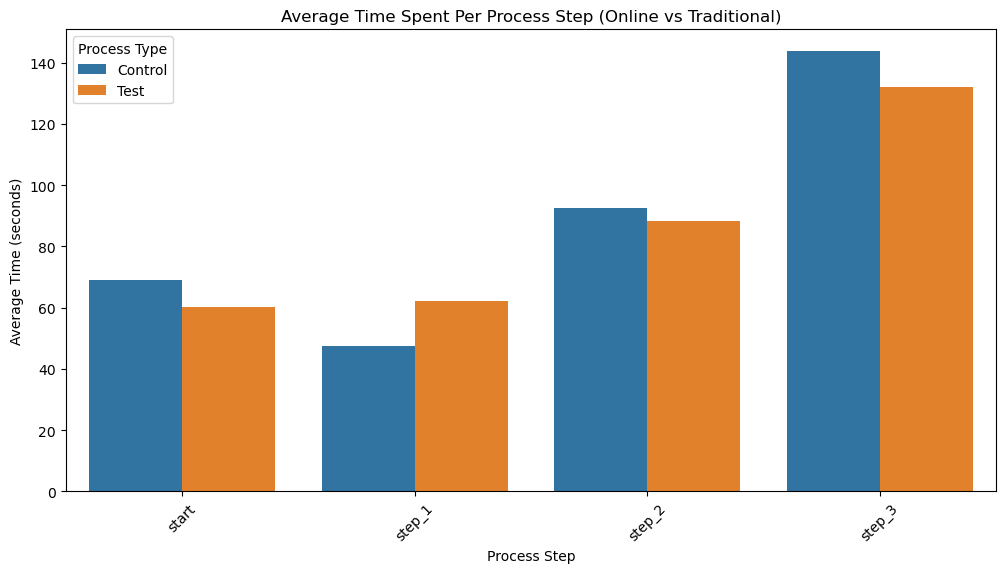

In [51]:
# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_corrected,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

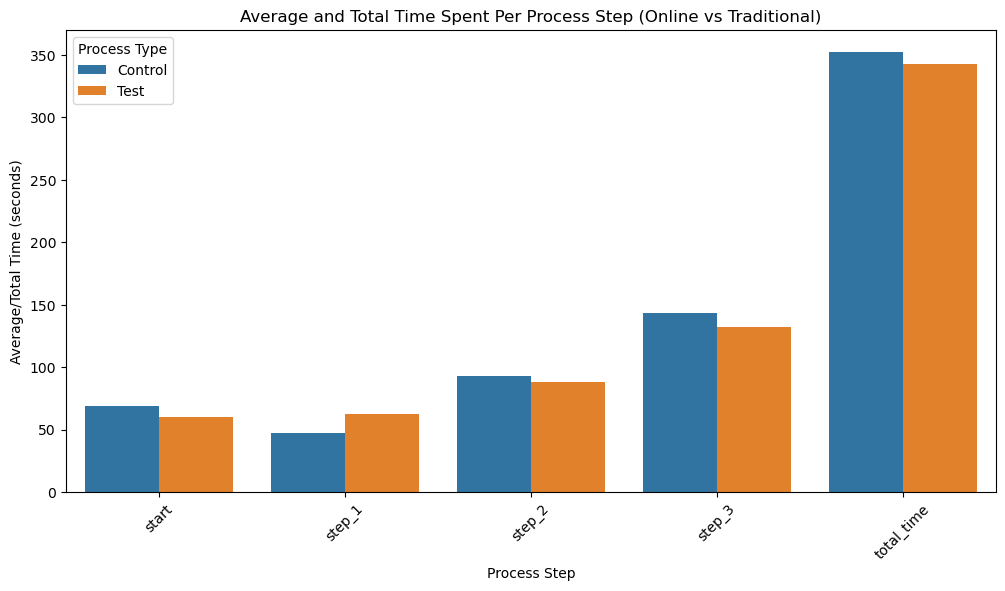

In [52]:
# Step 1: Calculate the cumulative time spent for each variation
total_time_spent = avg_step_duration_corrected.groupby('variation')['avg_time_spent_seconds'].sum().reset_index()
total_time_spent['process_step'] = 'total_time'

# Step 2: Append the total time to the original dataset
avg_step_duration_with_total = pd.concat([avg_step_duration_corrected, total_time_spent], ignore_index=True)

# Step 3: Define the order for the process steps, including the total time
order = ["start", "step_1", "step_2", "step_3", "total_time"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=avg_step_duration_with_total,
    x='process_step',
    y='avg_time_spent_seconds',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Average and Total Time Spent Per Process Step (Online vs Traditional)")
plt.xlabel("Process Step")
plt.ylabel("Average/Total Time (seconds)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [53]:
# Step 1: Calculate the total unique clients for each variation
total_clients = df.groupby('variation')['client_id'].nunique().reset_index()
total_clients.rename(columns={'client_id': 'total_clients'}, inplace=True)

# Step 2: Count unique clients reaching each step, grouped by variation and process step
clients_per_step = df.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
clients_per_step.rename(columns={'client_id': 'clients_per_step'}, inplace=True)

# Step 3: Merge with the total clients to calculate the percentage reaching each step
clients_per_step = clients_per_step.merge(total_clients, on='variation')
clients_per_step['percentage_reaching_step'] = (clients_per_step['clients_per_step'] / clients_per_step['total_clients']) * 100

# Display the results
print(clients_per_step[['variation', 'process_step', 'percentage_reaching_step']])

  variation process_step  percentage_reaching_step
0   Control      confirm                 63.083671
1   Control        start                 99.628005
2   Control       step_1                 83.809894
3   Control       step_2                 77.835767
4   Control       step_3                 72.350230
5      Test      confirm                 68.285922
6      Test        start                 98.895756
7      Test       step_1                 89.907298
8      Test       step_2                 82.350268
9      Test       step_3                 77.060802


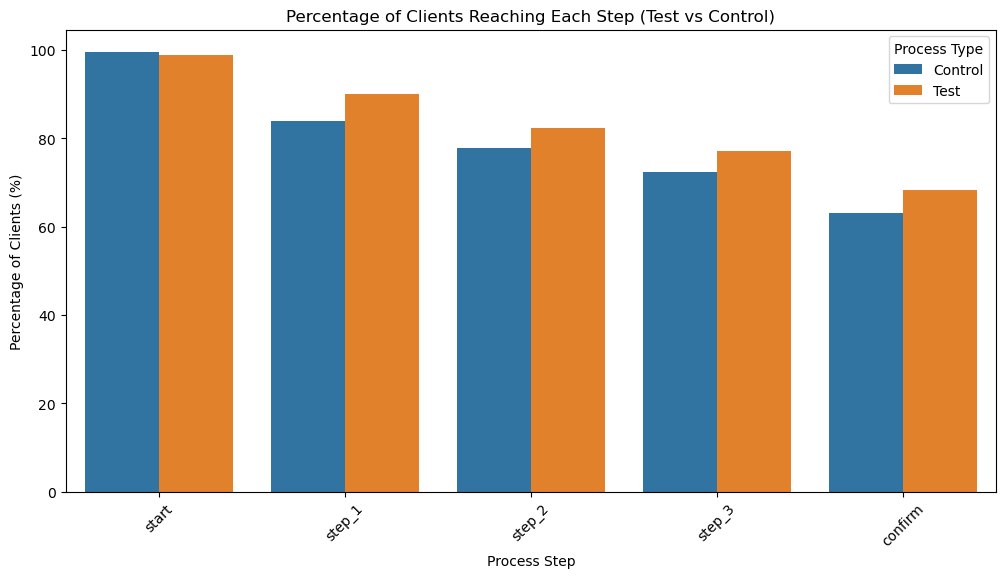

In [54]:
# Define the order for the process steps
order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar plot with the specified order
sns.barplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order
)

# Customize the plot
plt.title("Percentage of Clients Reaching Each Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Percentage of Clients (%)")
plt.legend(title="Process Type")
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Axes: xlabel='process_step', ylabel='percentage_reaching_step'>

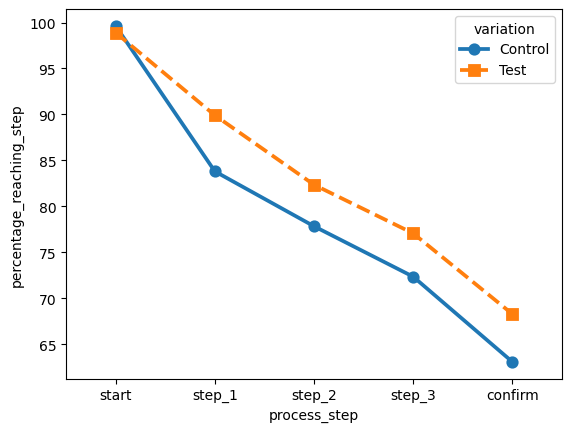

In [55]:
sns.pointplot(
    data=clients_per_step,
    x='process_step',
    y='percentage_reaching_step',
    hue='variation',
    order=order,
    markers=['o', 's'],  # Different markers for each variation
    linestyles=['-', '--'])  # Different line styles for variation